In [1]:
import idx2numpy
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms 
import torchvision
np.set_printoptions(threshold=np.inf)

In [2]:
def write_idx():
    path = Path("") 
    img = idx2numpy.convert_from_file(str(path / "t2-images.idx"))
    lbl = idx2numpy.convert_from_file(str(path / "t2-labels.idx"))
    save_imgs = np.zeros((2,28,28),dtype=np.float64)
    save_labels = np.zeros(2,dtype=np.uint8)
    save_imgs[0] = img[0]
    save_imgs[1] = img[1]
    save_labels[0] = lbl[0]
    save_labels[1] = lbl[1]

    
    
    idx2numpy.convert_to_file(str(path / "images.idx"),save_imgs)
    idx2numpy.convert_to_file(str(path / "labels.idx"),save_labels)
write_idx()

(2, 28, 28)
>f8
(2,)
uint8
[7 2]


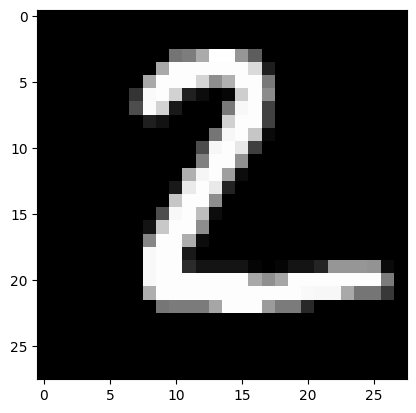

In [3]:
def func():
    # Reading
    path = Path("")
    i = 1
    ndarr = idx2numpy.convert_from_file(str(path / "images.idx"))
    print(ndarr.shape)
    print(ndarr.dtype)
    plt.imshow(ndarr[i],cmap="gray") # 20 30 50 60
    ndarr = idx2numpy.convert_from_file(str(path / "labels.idx"))
    print(ndarr.shape)
    print(ndarr.dtype)
    print(ndarr)
func()

In [20]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((1,1,28,28))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],10)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
def save_model(model):
    inputs = torch.rand((1,1,28,28),requires_grad=True).to(device)
    torch.onnx.export(model,inputs,"model.onnx",input_names=["input"],output_names=["output"],dynamic_axes={'input': { 0: 'batch_size' }, 'output': { 0: 'batch_size' }})


In [22]:
model = Model().to(device)
save_model(model)

In [23]:
from torchvision.datasets import MNIST
dataset = MNIST(download=True,root="dataset",transform=transforms.ToTensor())

In [24]:
loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=1024, 
                                           num_workers=6,
                                           shuffle=True
                                           )

In [25]:
def train(model,loss_func,optimiser,epochs):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

In [26]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())

In [27]:
train(model,loss_func,optimiser,50)

In [28]:
save_model(model)